In [4]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split 
import os

In [5]:
#insert the desired path containing combined data files
path = os.path.expanduser(r"~/Documents/python/identification_modified_proteins/bin_size_0.01/")

#changes current working directory to the path given 
directory = os.chdir(path)

In [6]:
#load processed training numpy array data and convert to pd dataframe
load_data = np.load('all_train_data_0.01_with_2+.npy', allow_pickle=True)
df = pd.DataFrame(load_data)

# Create feature and target arrays
X = df.drop(101300, axis=1) 
y = df[101300].astype('int') #last column is the modified or not modified feature

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4 , random_state=42)

t-Distributed Stochastic Neighbor Embedding or t-SNE - a powerful technique to visualize high dimensional data using feature extraction.t-SNE will maximize the distance in two-dimensional space between observations that are most different in a high-dimensional space. Because of this, observations that are similar will be close to one another and may become clustered. t-SNE does not work with non-numeric data as such so need to remove any non numeric. 

While fitting to the dataset, t-SNE will try different configurations and evaluate these with an internal cost function. High learning rates will cause the algorithm to be more adventurous in the configurations it tries out while low learning rates will cause it to be conservative. Usually, learning rates fall in the 10 to 1000 range. 

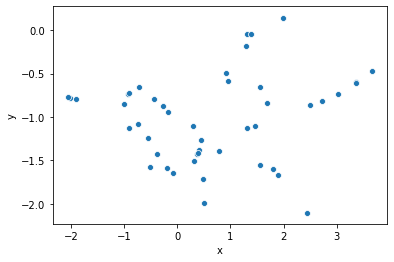

In [7]:
#create a TSNE() model with learning rate 50
m = TSNE(learning_rate=50)

#fit and transform the TSNE model to our numeric dataset. 
#this will project our high-dimensional dataset onto a NumPy array with two dimensions.
tsne_features = m.fit_transform(df)


#assign these two dimensions back to our original dataset naming them 'x' and 'y'.
df['x'] = tsne_features[:,0]
df['y'] = tsne_features[:,1]

#plot data using seaborn's .scatterplot() method on the x and y columns we just added.
sns.scatterplot(x='x', y='y', data=df)
plt.show()

No real correlation or defined groups of data points are seen with tsne. This was somewhat expected since there are no distinct groups of peptide sepctrum shapes, instead, there is a more continuous distribution of spectrum shapes, and thus, one undefined cluster. 

Need to use categorical features (mod/unmod) we excluded from the analysis initially to check if there are interesting structural patterns within this cluster.

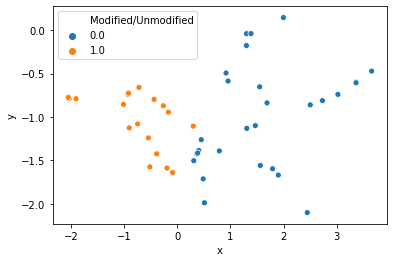

In [8]:
#rename column 101300 which contains the modified or unmodified feature to an appropriate title
df = df.rename(columns={101300: 'Modified/Unmodified'})

#use name for the hue, which is the colour to analyse clusters. 
sns.scatterplot(x='x', y='y', hue='Modified/Unmodified', data=df)
plt.show()

Thus t-SNE helped to visually explore our dataset and identify that there are defined clusters are present. 

Feature extraction is a good next step. Feature extraction is unlike feature selection where some features were simply dropped completely. It creates new features, which are in fact combinations of the original ones. There are powerful algorithms that will calculate the new features in a way that as much information as possible is preserved, but before we get into those, let's look at more simple feature extraction. 

While manual feature extraction is possible, due to the 101299 available features that we have, we need a very good understanding of each of these features to form new ones. It is only when you have good understanding of the features in your dataset you can sometimes combine multiple features into a new feature that makes the original ones obsolete. Furthermore, combining features by taking the average of multiple features comes with the cost of losing some information.

Instead, we can start with principal component analysis. You can describe the information captured by two features by using two perpendicular vectors that are aligned with the variance in the data, or even describe points using multiplications of the vectors.

For this technique it's important to scale the features first, so that their values are easier to compare. We do this with sklearn's StandardScaler(). 


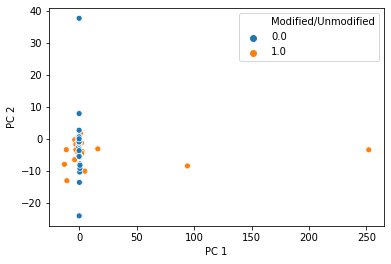

In [9]:
#scale the values with the StandardScaler()
scaler = StandardScaler()
std_df = scaler.fit_transform(df)

#can then create our PCA instance and apply the .fit_transform() method 
pca = PCA()
pca_df = pca.fit_transform(std_df)

#assign dimensions back to our pca dataset naming them 'x' and 'y', first two arrays (PC1 and PC2)
df['PC 1'] = pca_df[0, :]
df['PC 2'] = pca_df[1, :]

#plot the first principal component against the second principal component
sns.scatterplot(x='PC 1', y='PC 2', hue='Modified/Unmodified', data=df)
plt.show()

In [10]:
pca_df

array([[-1.06469177e+01,  4.96087182e+00, -1.27700895e+01, ...,
        -6.95378325e-03, -7.94623283e-03,  2.84072309e-13],
       [-1.31097996e+01, -1.01169118e+01, -7.96821350e+00, ...,
        -1.19168722e+00, -9.42629337e-01,  2.84072309e-13],
       [-1.21899634e+01, -8.16710859e+00, -1.12978122e+01, ...,
        -3.62029022e-02, -2.18725150e-02,  2.84072309e-13],
       ...,
       [-1.31096016e+01, -1.01478583e+01, -7.86586580e+00, ...,
        -1.62514030e+00, -2.23153341e+00,  2.84072309e-13],
       [-1.27615040e+01, -1.03097253e+01, -8.15994257e+00, ...,
        -4.62060761e-01, -1.02261117e+00,  2.84072309e-13],
       [-8.98989548e+00, -1.13648646e+01, -7.44502340e+00, ...,
        -3.45744533e-02, -3.40640761e-02,  2.84072309e-13]])

When we plot these values for all points in the dataset, our resulting point cluster no longer shows any correlation and therefore, no more duplicate information. If we would add a third feature to the original dataset we would also have to add a third principal component if we don't want to lose any information - this remains true as you keep adding features. You could describe a 100 feature dataset with 100 principal components. However this is unlikely to provide much informational value as the components are much harder to understand than the original features.

The components share no duplicate information and they are ranked from most to least important. We can access the explained variance ratio of each principal component after fitting the algorithm to the data using the .explained_variance_ratio_ attribute. 


In [11]:
#Inspect the explained variance ratio per component
print(pca.explained_variance_ratio_)

[1.70269342e-01 9.80622467e-02 8.17240279e-02 5.47314358e-02
 4.54027108e-02 3.67524620e-02 3.28829818e-02 3.20161858e-02
 2.97732165e-02 2.90801702e-02 2.79725648e-02 2.76823618e-02
 2.71953436e-02 2.59976825e-02 2.57696764e-02 2.49340420e-02
 2.32087058e-02 2.14159517e-02 2.08641916e-02 1.78340168e-02
 1.76807200e-02 1.65402432e-02 1.42375964e-02 1.24529079e-02
 1.08037678e-02 1.00629101e-02 9.42136048e-03 8.92496055e-03
 8.17530128e-03 6.50609077e-03 6.26413930e-03 5.31374619e-03
 2.56306212e-03 2.46162225e-03 2.15734462e-03 2.06573980e-03
 1.92440954e-03 1.71375319e-03 1.35182537e-03 1.27784423e-03
 1.19942613e-03 1.09360135e-03 8.94273112e-04 7.56804791e-04
 5.87232902e-04 2.30115994e-30]


In this case it tells us that the first components explains 17.2% of the variance in the data and the second the remaining 9.8%. When you are dealing with a dataset with a lot of correlation the explained variance typically becomes concentrated in the first few components. The remaining components then explain so little variance that they can be dropped. This is why PCA is so powerful for dimensionality reduction.

In [12]:
#Cumulative sum of the explained variance ratio
#see how much variance we can explain in total by using a certain number of components
print(pca.explained_variance_ratio_.cumsum())

[0.17026934 0.26833159 0.35005562 0.40478705 0.45018976 0.48694223
 0.51982521 0.55184139 0.58161461 0.61069478 0.63866734 0.66634971
 0.69354505 0.71954273 0.74531241 0.77024645 0.79345516 0.81487111
 0.8357353  0.85356932 0.87125004 0.88779028 0.90202788 0.91448078
 0.92528455 0.93534746 0.94476882 0.95369378 0.96186908 0.96837518
 0.97463931 0.97995306 0.98251612 0.98497774 0.98713509 0.98920083
 0.99112524 0.99283899 0.99419082 0.99546866 0.99666809 0.99776169
 0.99865596 0.99941277 1.         1.        ]


Using this extended dataset with 2+ masses, using just the first two components would allow us to keep a much lower 26.8% compared to the 40% we saw when we kept the data using only 1+ masses the variance in the data whereas we would have to use 18 components to keep 80% of the variance.

The lowest number of principal components to keep to avoid losing more than 10% of explained variance during dimensionality reduction is 23. 

Using PCA for dimensionality reduction allows you to decide how much of the explained variance you're willing to sacrifice. However, one downside of PCA is that the remaining components can be hard to interpret.

To improve understanding of the components it can help to look at the .components_ attribute. This tells us to what extent each component's vector is affected by a particular feature. The features that have the biggest positive or negative effects on a component can then be used to add a meaning to that component.

In [13]:
#shows first 4 rows of pca components 
pca_comp = pca.components_
print(pca_comp[0:4,])
pca_comp.shape

[[-1.43101139e-15 -7.56303491e-15  8.56421333e-16 ... -1.64135649e-03
   2.61061552e-03 -4.03547273e-03]
 [-4.56984325e-16 -1.92055644e-15  2.30826456e-16 ...  3.93191731e-03
  -3.49859947e-03  1.47229045e-03]
 [-1.05704005e-15 -4.26065039e-15  5.37670236e-16 ... -2.50707990e-03
   5.54138276e-03  2.45953184e-03]
 [ 7.47948419e-15 -2.11984758e-14  9.88241883e-16 ...  6.21688783e-03
  -4.86360786e-03  2.51722002e-03]]


(46, 101303)

Original data consisted of x-axis as binned intensities as cross a mass range, and y-axis as modified or unmodified. 

Each array can be thought of as a principal component (PC). As can be seen the first two columns of each array, the feature has very litte meaning to that component. Thus, these are likely to be 0 intensity values. 

Scaling the data before applying PCA means we're able to combine both operations in a pipeline. We pass the two operations to the Pipeline() class in the form of two tuples inside a list. Within each tuple we give our operation a name, 'scaler' and 'reducer'. 

In [14]:
#create pipeline
pipe = Pipeline([('scaler', StandardScaler()), 
                ('reducer', PCA(n_components=16))])

pc = pipe.fit_transform(df)

print(pc[:,:2])

[[-10.64416216   4.96233365]
 [-13.10853574 -10.11615416]
 [-12.18870452  -8.16662775]
 [-12.10691712  15.35845062]
 [-14.13052493  -7.49925281]
 [-10.42774462   7.05194138]
 [-13.3536984   -9.70139126]
 [-14.08978972  -5.83861712]
 [-13.64690144 -10.04057563]
 [-12.07182273  -3.20827448]
 [-11.89918193  -7.20517703]
 [-12.78551358  -6.75165679]
 [-13.41635019 -10.05152262]
 [ -4.25978164 391.80274281]
 [-12.87588697  -8.23952387]
 [-13.73215802  -8.68659074]
 [-13.37137246 -10.08367017]
 [-11.9093203  -10.02953927]
 [-12.68755385 -10.56174877]
 [-11.75477026 -10.84179546]
 [-13.12883431 -10.08173575]
 [-13.03697121 -10.8664375 ]
 [517.80503015  -5.23549508]
 [-12.52538361 -10.85451435]
 [-11.66828563 -11.92205329]
 [-13.05812608 -10.13417232]
 [-13.26606262 -10.22658783]
 [ -3.38344491 -12.98376679]
 [ -9.3964497  -12.07627326]
 [-12.9173045  -10.63693884]
 [-13.31129042 -10.28193273]
 [-11.8816408  -11.16488573]
 [-11.88462485 -10.48281231]
 [-12.25095845 -10.89523541]
 [ -8.11810004

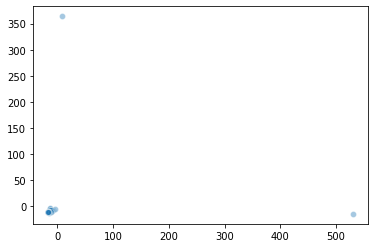

In [28]:
#create pipeline
pipe = Pipeline([('scaler', StandardScaler()), 
                ('reducer', PCA(n_components=16))])

#fit and transform onto our df
pc = pipe.fit_transform(df)

#extract the only categorial data we have: modified/unmodified feature. 
mod_category = df['Modified/Unmodified']
mod_category = pd.Series(mod_category)

#replace 0 and 1 with modified and unmodified titles 
mod_category = mod_category.replace({0: 'Unmodified'})
mod_category = mod_category.replace({1: 'Modified'})

#add the first two principal components to our dataframe and plot them
mod_category['PC 1'] = pc[:, 0]
mod_category['PC 2'] = pc[:, 1]

sns.scatterplot(data=mod_category, x='PC 1', y='PC 2', alpha=0.4)

Since our data is not categorical and only has one categorical feature: the output, categorial PCA provides less informational value as can be seen in the above graph. Usually, PCA is not the preferred algorithm to reduce the dimensionality of categorical datasets but checks can be made to see whether they align with the most important sources of variance in the data. 

To go beyond data exploration, we can add a model to the pipeline. We can add a random forest classifier and will predict gender on the 101300 numeric features of the dataset. I've told the PCA class to only calculate 3 components with the n_components parameter. Once the pipeline is fit to the training data we can access the steps within by indexing over the .steps attribute. PCA is the second step and therefore has index one. This returns a tuple with the name of the step first and actual algorithm second.

Using the .explained_variance_ratio_ attribute and taking its cumulative sum we see that these three components, only, explain 6.6% of the variance in the dataset. However, when we check the accuracy on the test set we get 88.2%

In [15]:
#build the pipeline
pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('reducer', PCA(n_components=3)),
        ('classifier', RandomForestClassifier(random_state=0))])

#fit the pipeline to the training data
pipe.fit(X_train, y_train)

#score the accuracy on the test set
accuracy = pipe.score(X_test, y_test)

#prints the explained variance ratio and accuracy
print(pipe.steps[1][1].explained_variance_ratio_)
print('{0:.1%} test set accuracy'.format(accuracy))

[0.27512629 0.09226255 0.07787965]
42.1% test set accuracy


In [16]:
#let PCA select 90% of the variance
pipe = Pipeline([('scaler', StandardScaler()),
                 ('reducer', PCA(n_components=0.9))])

#fit the pipe to the data
pipe.fit(df)

print('{} components selected'.format(len(pipe.steps[1][1].components_)))

23 components selected


23 components was confirmed by our analysis using pca.explained_variance_ratio_.cumsum() previously. 

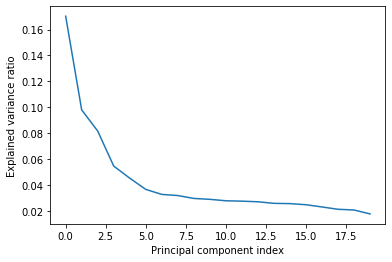

In [18]:
#pipeline a scaler and pca selecting 10 components
pipe = Pipeline([('scaler', StandardScaler()),
                 ('reducer', PCA(n_components=20))])

#fit the pipe to the data
pipe.fit(df)

#plotting the explained variance ratio
plt.plot(pipe.steps[1][1].explained_variance_ratio_)

plt.xlabel('Principal component index')
plt.ylabel('Explained variance ratio')
plt.show()

Component index so n+1 i.e the 5 is where the dip occurs so 6 components reduces the dataset without compromising too much on explained variance. 